In [15]:
import os
os.environ["SPS_HOME"] = "/Users/ncv375/Desktop/Year1/spatialSED/quick_repo_natalia/fsps"
import numpy as np
from sbipix import sbipix
from sbipix import *
import pickle
import torch
from scipy import stats
import matplotlib.font_manager as fm
import matplotlib.patches as patches
import matplotlib.ticker as ticker

sx = sbipix()
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [42]:
#sx.remove_filters=[7, 10, 12, 13]
sx.filter_path = './obs/obs_properties/'
sx.load_obs_features()

Observational features loaded


In [43]:
local_path=os.path.abspath('.')
sx.model_name = 'post_obs_jades_tau_GSz14test.pkl' # Adjust this to your model, this is a model trained on cpu up to z=7.5 with tau-delayed SFHs on 100k simulations
sx.filter_path = './obs/obs_properties/'
sx.model_path = './library/'
sx.n_simulation = 100000
sx.parametric = True
sx.both_masses = True
sx.infer_z = True
sx.infer_onlyz = True
sx.include_limit = True
sx.condition_sigma = True
sx.include_sigma = True

In [ ]:
phot=np.load('full_phot_test_GSz14_newsbipix.npy',allow_pickle=True)
err=np.load('full_err_test_GSz14_newsbipix.npy',allow_pickle=True)
c_array = np.load('c_arr_test_GSz14_newsbipix.npy',allow_pickle=True)

In [46]:
filters_name=[
    "JWST_NIRCam_F090W",
    "JWST_NIRCam_F115W",
    "JWST_NIRCam_F150W",
    "JWST_NIRCam_F182M",
    "JWST_NIRCam_F200W",
    "JWST_NIRCam_F210M",
    "JWST_NIRCam_F277W",
    "JWST_NIRCam_F335M",
    "JWST_NIRCam_F356W",
    "JWST_NIRCam_F410M",
    "JWST_NIRCam_F430M",
    "JWST_NIRCam_F444W",
    "JWST_NIRCam_F460M",
    "JWST_NIRCam_F480M",
    "HST_ACS.F435W",
    "HST_ACS.F606W",
    "HST_ACS.F775W",
    "HST_ACS.F814W",
    "HST_ACS.F850LP"
]

In [77]:
def setup_arrays(phot=phot, err=err, c_array=c_array, sn_limit=10, ranges=[10794, 10684, 16249, 16054]):
    # Calculate S/N for F277W, F356W, F444W filters
    # Filter indices: F277W=6, F356W=8, F444W=11 (adjust if needed)
    filters_sn = [6, 8, 11]  # F277W, F356W, F444W

    # print(f"Using filters for S/N calculation: {[hdf['metadata']['filters'][i].decode('utf-8') for i in filters_sn]}")

    s_n = np.nanmean(phot[:, filters_sn] / err[:, filters_sn], axis=1)

    # Select pixels above S/N limit
    if sn_limit is None:
        sn_limit = 5.0  # Default S/N limit
        
    max_sn = np.where(s_n > sn_limit)[0]

    print(f'Minimum S/N = {np.nanmin(s_n[max_sn]):.2f}')
    print(f'Computing posteriors for {len(max_sn)} pixels (S/N > {sn_limit})')
    print(f'Total pixels in galaxy: {len(phot)}')

    if len(max_sn) == 0:
        print(f"ERROR: No pixels above S/N limit {sn_limit}!")
        # return None

    phot_gal = np.empty((len(phot[0]), ranges[0]-ranges[1], ranges[2]-ranges[3]))# size of cutout, store to not hardcode this #, 4500, 4500))
    phot_gal[:] = np.nan
    err_gal = np.empty((len(phot[0]), ranges[0]-ranges[1], ranges[2]-ranges[3]))
    err_gal[:] = np.nan

    c_gal = np.array(c_array[0])
    for k in range(len(c_gal)):
        phot_gal[:, c_gal[k, 0], c_gal[k, 1]] = phot[k, :]
        err_gal[:, c_gal[k, 0], c_gal[k, 1]] = err[k, :]

    return phot_gal, err_gal, c_gal, max_sn

In [80]:
def plot_photerr(phot_gal=phot_gal, err_gal=err_gal, filters_name=filters_name, box=[20, 80, 40, 140]):
    i_filter = range(len(phot[0]))  
    for i in i_filter:
        try:
            plt.imshow(phot_gal[i, box[0]:box[1], box[2]:box[3]], origin='lower', norm='log', cmap='Grays')
            plt.colorbar(label='$\\mu$Jy')
            plt.title(filters_name[i][-5:])
            plt.show()
        except:
            print('An error occurred when plotting the photometry for '+filters_name[i][-5:]+', ignoring...')
            pass

        try:
            plt.imshow(phot_gal[i, box[0]:box[1], box[2]:box[3]]/err_gal[i, box[0]:box[1], box[2]:box[3]], origin='lower', cmap='Grays')
            plt.colorbar(label='S/N')
            plt.title(filters_name[i][-5:]+' S/N')
            plt.show()
        except:
            print('An error occurred when plotting the S/N for '+filters_name[i][-5:]+', ignoring...')
            pass

In [79]:
phot_gal, err_gal, c_gal, max_sn = setup_arrays()

Minimum S/N = 10.01
Computing posteriors for 300 pixels (S/N > 10)
Total pixels in galaxy: 21450


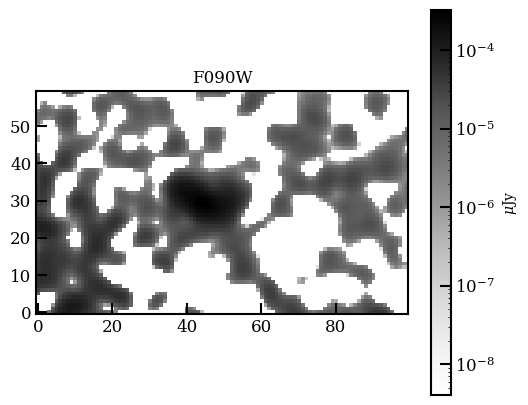

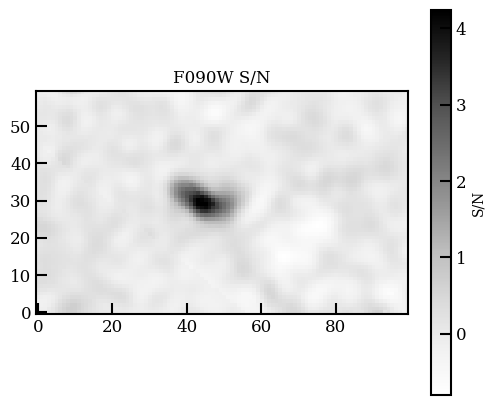

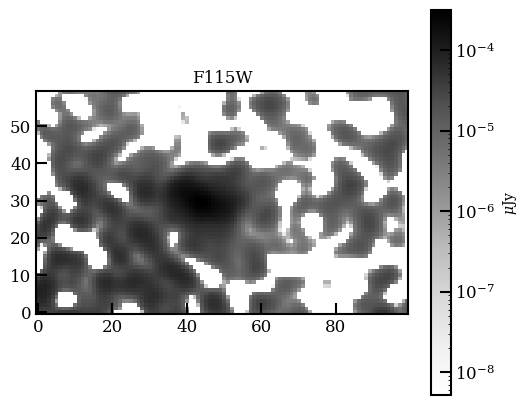

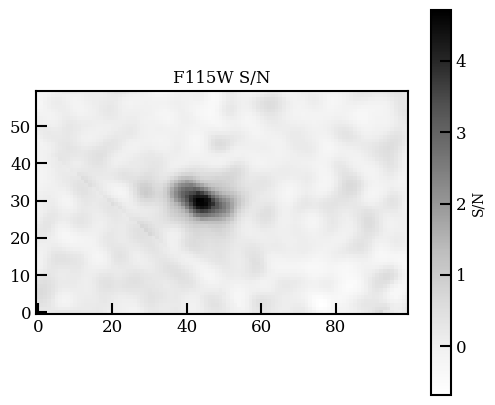

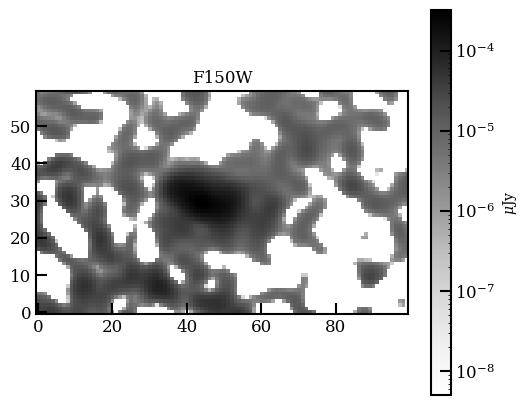

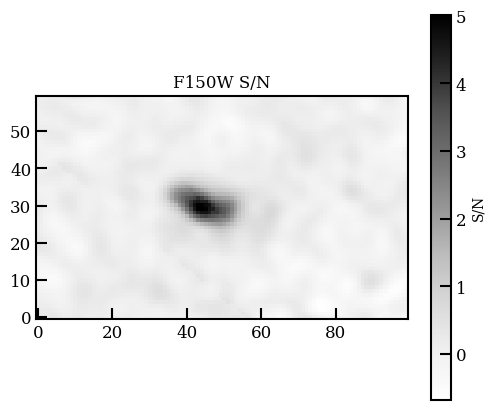

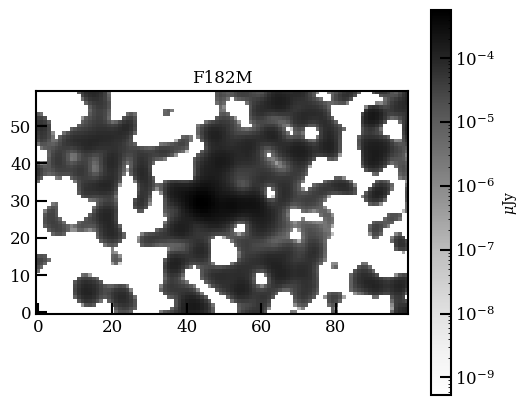

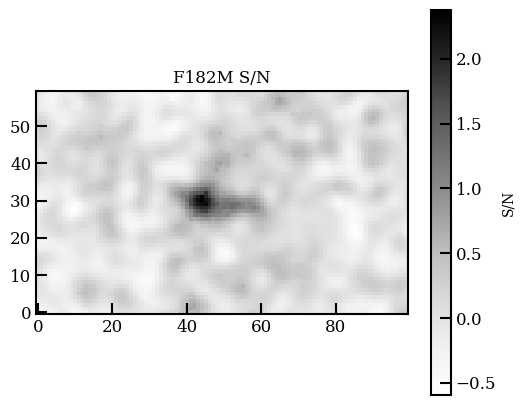

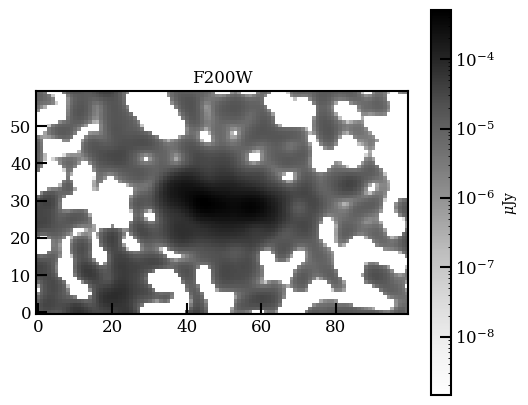

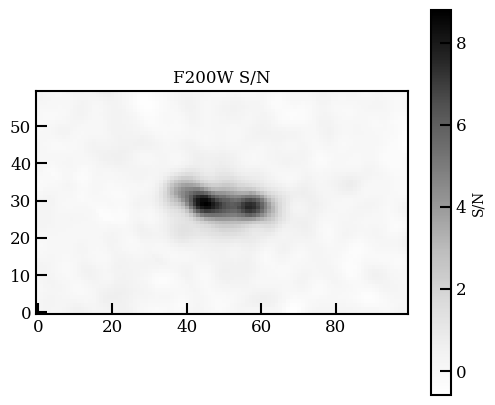

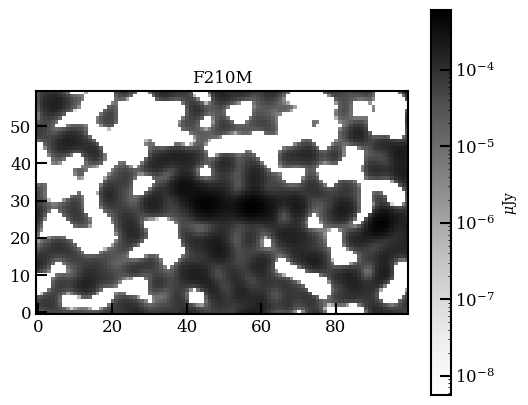

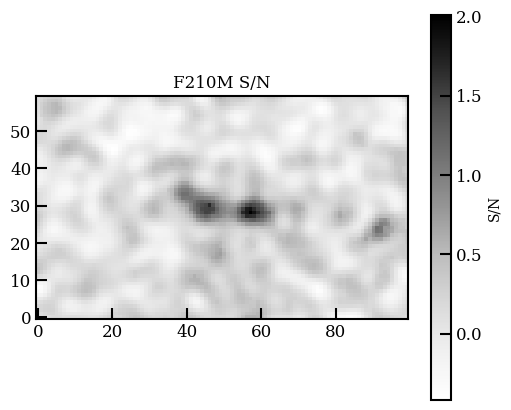

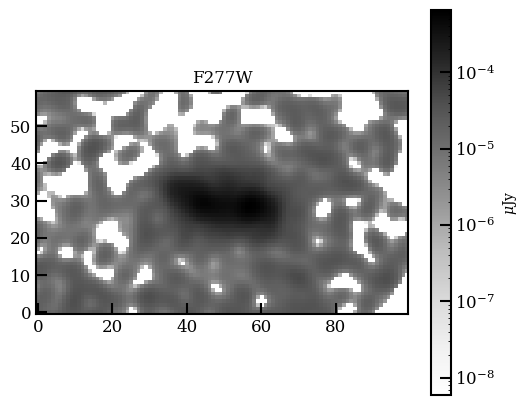

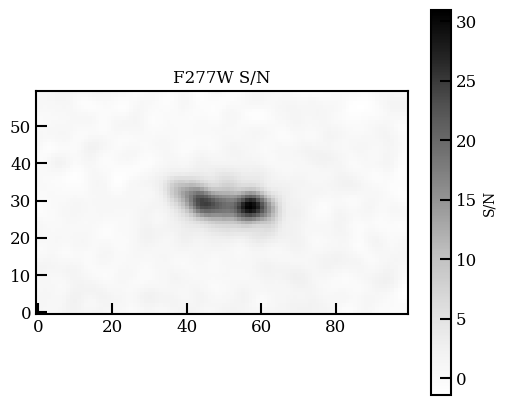

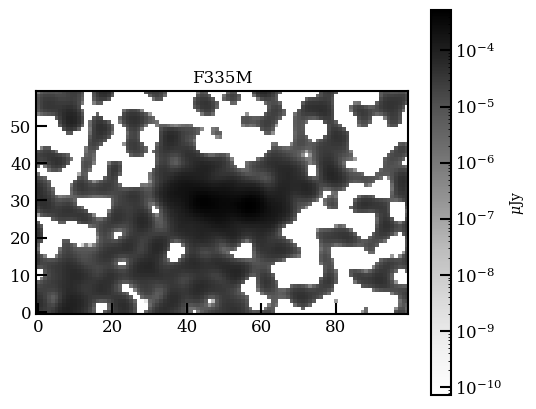

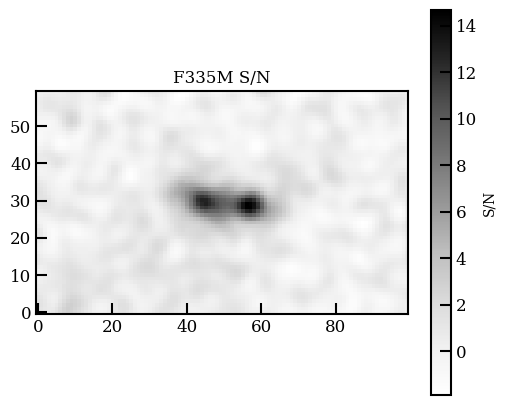

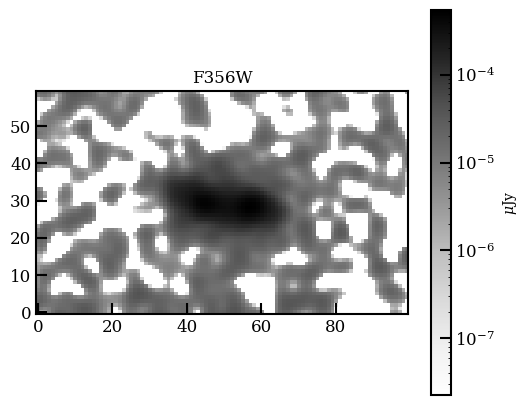

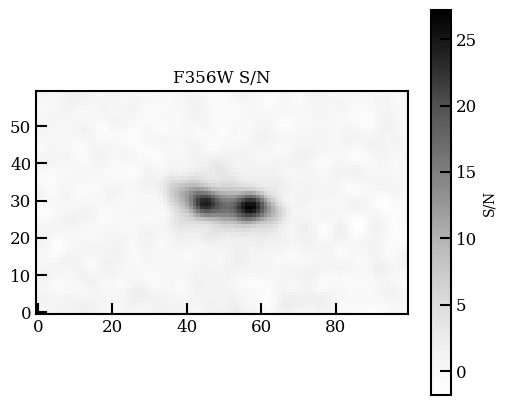

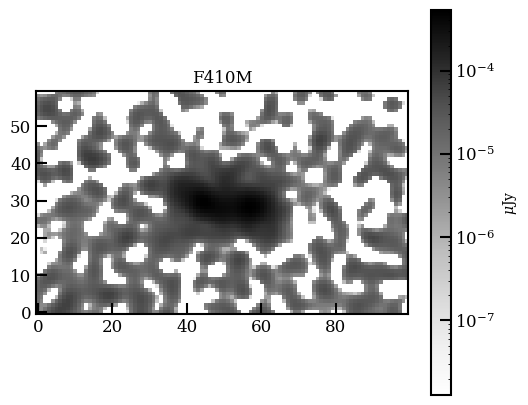

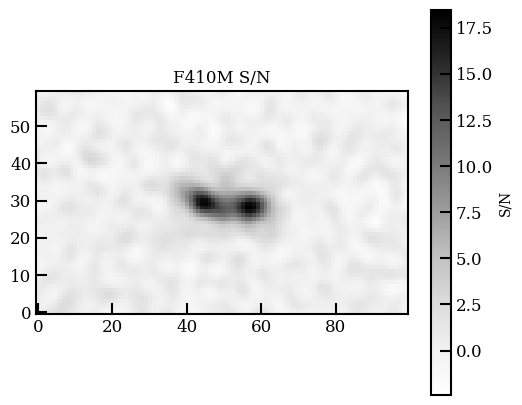

An error occurred when plotting the photometry for F430M, ignoring...


ValueError: Invalid vmin or vmax

<Figure size 600x500 with 3 Axes>

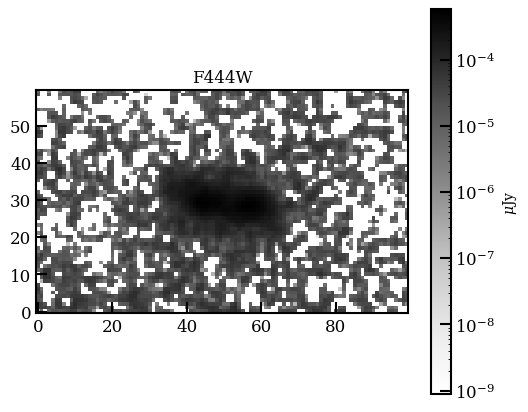

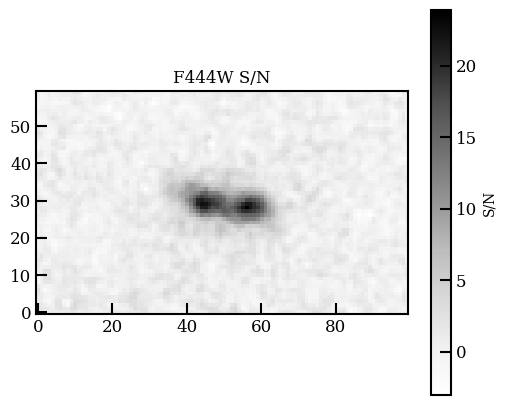

An error occurred when plotting the photometry for F460M, ignoring...


ValueError: Invalid vmin or vmax

<Figure size 600x500 with 3 Axes>

An error occurred when plotting the photometry for F480M, ignoring...


ValueError: Invalid vmin or vmax

<Figure size 600x500 with 3 Axes>

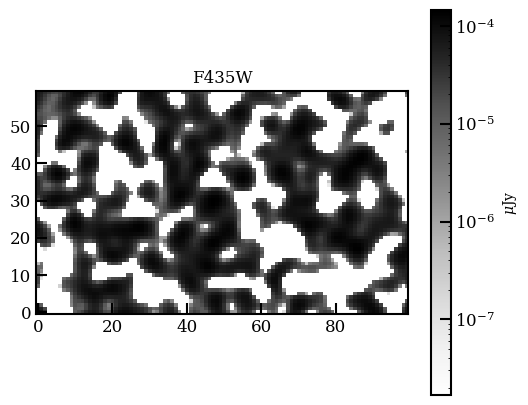

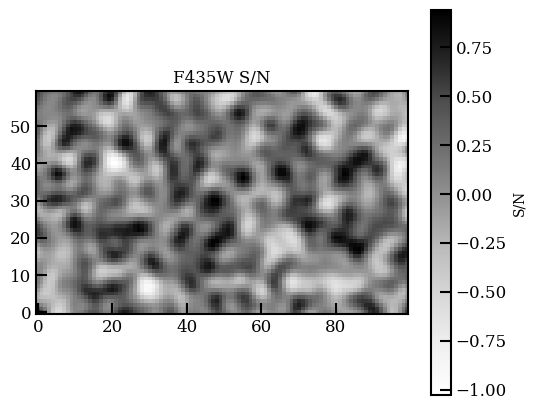

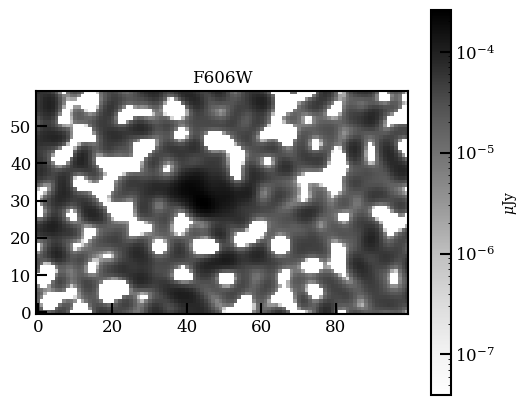

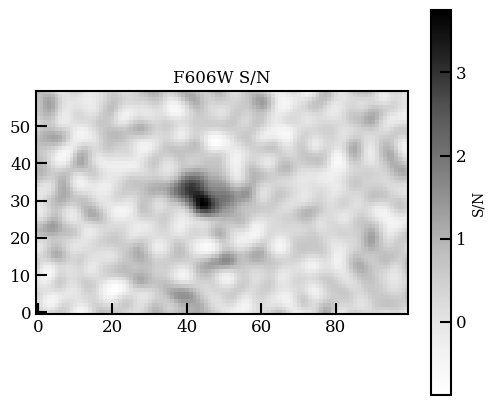

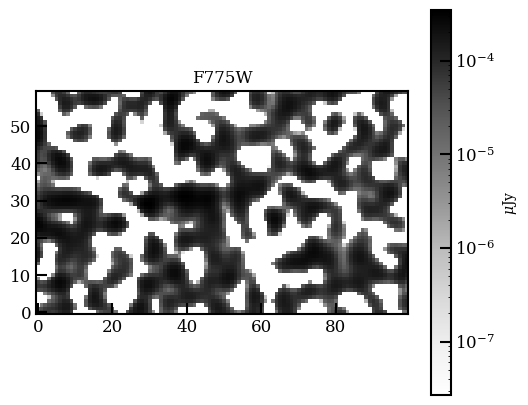

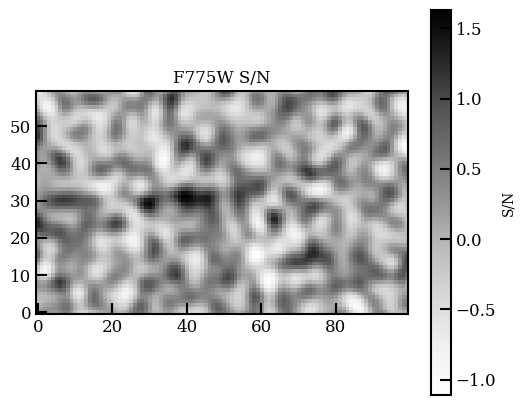

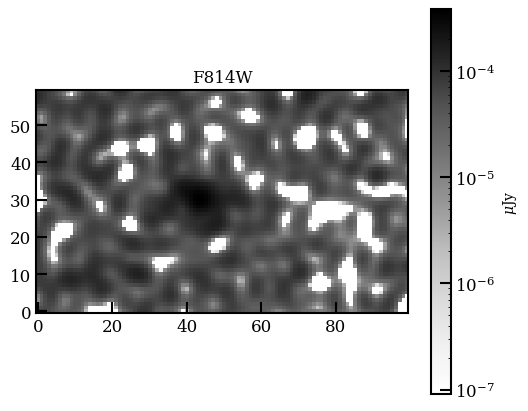

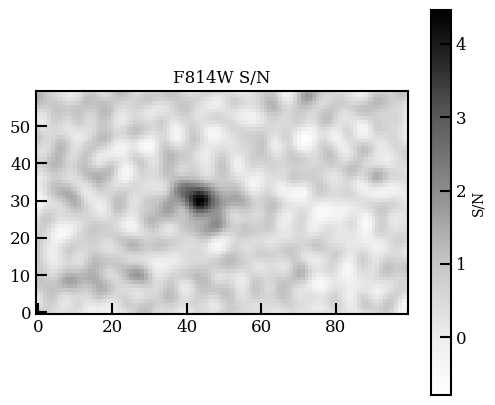

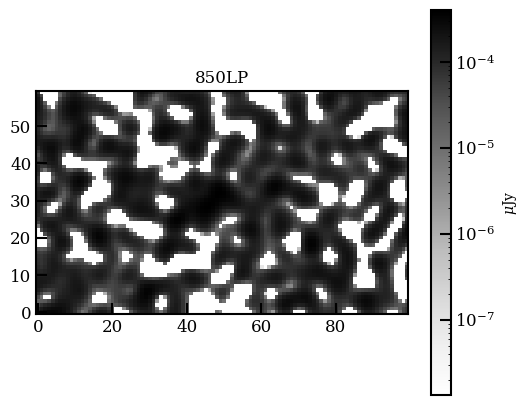

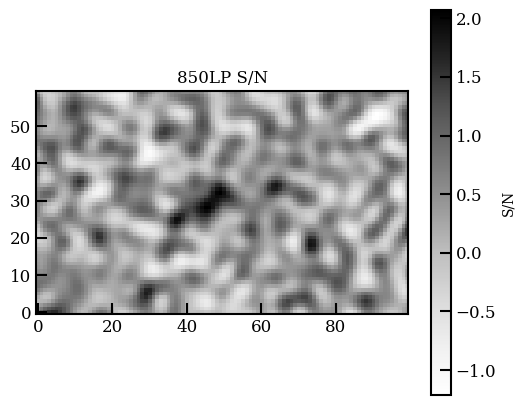

In [81]:
plot_photerr()

In [83]:
print("Computing resolved posteriors...")
p = sx.get_posteriors_resolved(
    phot_arr=phot[max_sn[:], :], 
    n_gal=1,
    n_samples=500, 
    sigma_arr=err[max_sn[:], :])


Computing resolved posteriors...


100%|██████████| 300/300 [00:02<00:00, 134.20it/s]


In [85]:
def plot_theta_z(n_theta=1, phot_gal=phot_gal, c_gal=c_gal, max_sn=max_sn, p=p, box=[35, 65, 70, 110]):
    theta_gal = np.full((n_theta, phot_gal.shape[1], phot_gal.shape[2]), np.nan)
    print(theta_gal.shape)

    for k in range(len(p[0])):
        if k < len(max_sn):
            pixel_idx = max_sn[k]
            if pixel_idx < len(c_gal):
                x, y = c_gal[pixel_idx]
                
                t = np.mean(p[0][k, :, 0], axis=0)

                theta_gal[:, x, y] = t

    fig, ax = plt.subplots(figsize=(6, 8))

    im = ax.imshow(theta_gal[0, box[0]:box[1], box[2]:box[3]], origin='lower', cmap='jet')
    cbar = plt.colorbar(mappable=im, label='z', location='top', ax=ax)

    plt.show()


(1, 110, 195)


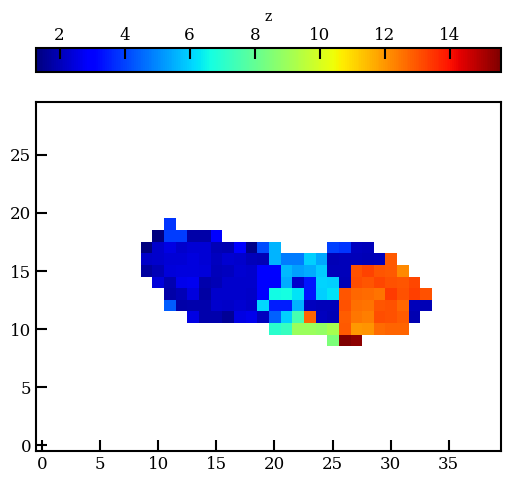

In [86]:
plot_theta_z()

In [ ]:
def plot_parameter_maps_nataliav(posteriors=p[0], max_sn=max_sn, coordinates=c_gal, labels=['z'], phot_gal=phot_gal, 
                       ranges=[16054, 16249, 10684, 10794], metric='mean', cmap='viridis', savefig=False, galaxy_id=1, 
                       output_dir='', plot_fraction=False, psf_fwhm=5.36, sx=sx, filters=filters_name, 
                       f444w_idx=11):
    """Plot parameter maps from posteriors"""
    
    n_theta = 1
    theta_gal = np.full((n_theta, phot_gal.shape[1], phot_gal.shape[2]), np.nan)
    print(theta_gal.shape)
    
    # Fill parameter maps
    for k in range(len(posteriors)):
        if k < len(max_sn):
            pixel_idx = max_sn[k]
            if pixel_idx < len(coordinates):
                x, y = coordinates[pixel_idx]
                
                p = posteriors[k, :, :]
                
                if metric == 'mean':
                    t = np.mean(p, axis=0)
                elif metric == 'median':
                    t = np.median(p, axis=0)
                elif metric == 'mode':
                    t = stats.mode(np.around(p, 1), axis=0, keepdims=False)[0]
                elif metric == 'std':
                    t = np.std(p, axis=0)
                
                theta_gal[:, x, y] = t
    
    # Calculate fraction of fitted pixels
    total_pixels = len(coordinates)
    fitted_pixels = len(max_sn)
    ratio = fitted_pixels / total_pixels if total_pixels > 0 else 0
    print(f'Fitted pixels: {fitted_pixels}/{total_pixels} ({ratio:.2%})')
    
    # Set NaN for photometry where no parameters fitted
    nan_mask = np.isnan(theta_gal[0, :, :])
    print(len(theta_gal[0, nan_mask]))
    phot_gal[:, nan_mask] = np.nan
    
    # Plot F444W with overlays first
    fig, ax = plt.subplots(figsize=(6, 8))
    phot_slice = phot_gal[f444w_idx, ranges[0]:ranges[1], ranges[2]:ranges[3]]
    
    if np.any(np.isfinite(phot_slice)):
        im = ax.imshow(phot_slice, origin='lower', norm='log', cmap=cmap)
        filter_name = filters[f444w_idx].split('_')[-1] if '_' in filters[f444w_idx] else filters[f444w_idx]
        cbar = plt.colorbar(mappable=im, label=f'Flux in {filter_name} [μJy]', 
                          location='top', ax=ax)
        cbar.ax.tick_params(labelsize=16)
    
    # Add PSF circle if requested
    if psf_fwhm is not None:
        center_x, center_y = (10794-10684)//2, (16249-16054)//2#size//4, size//4  # Bottom left corner
        circle = patches.Circle((center_x, center_y), radius=psf_fwhm/2, 
                              edgecolor='black', facecolor='black', linewidth=2)
        ax.add_patch(circle)
        ax.text(center_x, center_y - psf_fwhm, 'PSF', ha='center', va='top', 
               fontsize=14, color='black')
    
    # Add fitted pixel fraction if requested
    if plot_fraction:
        ax.text(0.05, 0.95, f'Fitted: {ratio:.1%}', fontsize=16, 
               transform=ax.transAxes, color='white', 
               bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
    
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_title(f'Galaxy {galaxy_id} - {filter_name}', fontsize=16)
    
    if savefig:
        plt.savefig(f'{output_dir}/{galaxy_id}/ID_{galaxy_id}_{filter_name}_reference.pdf', 
                   bbox_inches='tight')
    plt.show()
    
    # Plot parameter maps
    for i in range(n_theta):
        fig, ax = plt.subplots(figsize=(6, 8))
        
        param_slice = theta_gal[i, ranges[0]:ranges[1], ranges[2]:ranges[3]]
        print(param_slice.shape)
        
        # Handle reversed colormaps for certain parameters
        if sx.both_masses:
            reverse_params = [2, 3, 4]  # SFR, age-related parameters
        else:
            reverse_params = [1, 2, 3]
        
        cmap_use = cmap + '_r' if i in reverse_params else cmap
        
        if np.any(np.isfinite(param_slice)):
            im = ax.imshow(param_slice, origin='lower', cmap=cmap_use)
            
            # Add total stellar mass annotation for mass parameter
            if i == 0 and 'log(M' in labels[i]:
                total_mass = np.log10(np.nansum(10 ** theta_gal[i, :, :]))
                ax.text(0.05, 0.05, f'log(M*,tot/M☉) = {total_mass:.2f}', 
                       fontsize=16, transform=ax.transAxes, color='white',
                       bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
            
            cbar = plt.colorbar(mappable=im, label=labels[i], location='top', ax=ax)
            cbar.ax.tick_params(labelsize=16)
        else:
            ax.text(0.5, 0.5, 'No valid data', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=16)
        
        ax.set_xticks([])
        ax.set_yticks([])
        #ax.set_title(f'Galaxy {galaxy_id} - {labels[i]}', fontsize=16)
        
        if savefig:
            plt.savefig(f'{output_dir}/{galaxy_id}/ID_{galaxy_id}_param_{i}_{labels[i].replace("/", "_")}.pdf', 
                       bbox_inches='tight')
        plt.show()